In [1]:
import sys
sys.path.append("../")

In [2]:
from src.nnsrc.dense import NeuralNetwork

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [4]:
from matplotlib.pyplot import plot, legend, show, errorbar

In [5]:
data = pd.read_csv('../src/data/regression/data.cube.train.100.csv')
X = data[["x"]].values
Y = data["y"].values.reshape(-1,1)

In [6]:
test_data = pd.read_csv('../src/data/regression/data.cube.test.100.csv')
test_X = test_data[["x"]].values
test_Y = test_data['y'].values.reshape(-1,1)

In [7]:
def train(data, X, Y, test_data, test_X, test_Y, scale_x=False, scale_y=False, alpha=0.7, epochs=15000, batch_size=32, beta=0.9,
                    n_neurons_per_layer=[1, 50, 50, 50, 1], act_funcs=['relu','relu', 'relu', 'relu', 'linear'],
                    use_bias=True, problem='regression', seed=1, verbose=True, error_function=None):
    X = X.copy()
    Y = Y.copy()
    test_X = test_X.copy()
    test_Y = test_Y.copy()
    X_train_scaler = MinMaxScaler((0,1))
    Y_train_scaler = MinMaxScaler((0,1))
    if scale_x:
        X = X_train_scaler.fit_transform(X)
        test_X = X_train_scaler.transform(test_X)
    if scale_y:
        Y = Y_train_scaler.fit_transform(Y)
        test_Y = Y_train_scaler.transform(test_Y)
    n_layers = len(n_neurons_per_layer)
    nn2 = NeuralNetwork(seed=seed, n_layers=n_layers,
                    n_neurons_per_layer=n_neurons_per_layer, act_funcs=act_funcs, error_function=error_function,
                    bias=use_bias, problem=problem)

    if verbose:
        for layer in nn2.layers:
            print(layer.name, layer.input_dim, layer.output_dim)
        
    training_history= nn2.train(X.T, Y, alpha=alpha, epochs=epochs, batch_size=batch_size, beta=beta, full_history=False)
    #return history, grads_values
    #return history
    if verbose:
        plot(training_history['metrics'])
        show()
    
    y_hat = nn2.predict(X.T).reshape(-1,1)
    train_score = 1 - np.linalg.norm(y_hat - Y)/(np.linalg.norm(Y.mean()-Y))

    if verbose:
        print('train l2 norm:', np.linalg.norm(y_hat - Y))
        print('train r2 score:', train_score)
    
    if scale_y:
        y_hat = Y_train_scaler.inverse_transform(y_hat)
        #y_hat = MinMaxScaler().fit_transform(y_hat.reshape(-1,1))
        
    data['y_predicted'] = y_hat
    if verbose:
        plot(*zip(*sorted(zip(data.x, data.y))), label='train data')
        plot(*zip(*sorted(zip(data.x, data.y_predicted))), label='train pred')
        legend()
        show()
    
    test_y_hat = nn2.predict(test_X.T).reshape(-1,1)
    test_score = 1 - np.linalg.norm(test_y_hat - test_Y)/(np.linalg.norm(test_Y.mean()-test_Y))
    
    if verbose:
        print('test l2 norm:', np.linalg.norm(test_y_hat - test_Y))
        print('test r2 score:', test_score)
    
    if scale_y:
        test_y_hat = Y_train_scaler.inverse_transform(test_y_hat)
        #y_hat = MinMaxScaler().fit_transform(y_hat.reshape(-1,1))
        
    test_data['y_predicted'] = test_y_hat
    if verbose:
        plot(*zip(*sorted(zip(test_data.x, test_data.y))), label='test data')
        plot(*zip(*sorted(zip(test_data.x, test_data.y_predicted))), label='test pred')
        legend()
        show()
    return training_history, train_score, test_score

In [8]:
# EXPERIMENT 1

scale_x = True
scale_y = True
#alpha=0.7
#epochs=1000
batch_size=50
beta=0.9
#activation_function = 'relu'
use_bias=True

outs = []

import statistics
for alpha in [0.7, 0.3, 1.]:
    #neurons_in_hidden_layer in [16, 32, 64]
    for activation_function in ['relu', 'sigmoid', 'linear']:
        for nr_of_hidden_layers in [0, 1, 2, 3, 4]:
            for neurons_in_hidden_layer in [16, 32, 64]:
                n_neurons_per_layer=[1] + [neurons_in_hidden_layer]*nr_of_hidden_layers + [1]
                act_funcs=[activation_function]*(nr_of_hidden_layers+1)+['linear']
                
                for epochs in [100, 500, 1000, 2000, 5000]:
                    print('got epoch')
                    train_scores = []
                    test_scores = []
                    config = {'scale_x': scale_x,
                                 'scale_y': scale_y,
                                 'alpha': alpha,
                                 'epochs': epochs,
                                 'batch_size': batch_size,
                                 'beta': beta,
                                 'n_neurons_per_layer': n_neurons_per_layer,
                                 'act_funcs': act_funcs,
                                 'use_bias': use_bias}
                    print('running config:', config)
                    
                    for seed in range(10):
                        training_history, train_score, test_score = train(data, X, Y, test_data, test_X, test_Y, 
                                                                          **config,
                                                                          problem='regression', seed=seed, verbose=False)
                        train_scores.append(train_score)
                        test_scores.append(test_score)
                        print('got seed',seed)

                    train_values = statistics.mean(train_scores), statistics.stdev(train_scores)
                    test_values = statistics.mean(test_scores), statistics.stdev(test_scores)
                    outs.append((config, train_values, test_values))
                    print(train_values, test_values)
                    if nr_of_hidden_layers == 0:
                        break
import pickle
with open('exp_1.pickle', 'wb') as handle:
    pickle.dump(outs, handle)


In [9]:
# OR

In [10]:
import pickle

file = open('exp_1.pickle', 'rb')
outs = pickle.load(file)
file.close()

In [11]:
df = pd.DataFrame([{**conf, 'train_mean': train_mean, 'train_std': train_std, 'test_mean': test_mean,'test_std':test_std, 'nn_p_layer': conf['n_neurons_per_layer'][1] if len(conf['n_neurons_per_layer'])>2 else 0, 'act_func': conf['act_funcs'][0], 'n_hidden_layers': len(conf['n_neurons_per_layer'])-2} for conf,(train_mean, train_std),(test_mean, test_std) in outs])

# best architecture per activation function

df.sort_values('train_mean', ascending=False).groupby('act_func').first().sort_values('train_mean', ascending=False)

,scale_x,scale_y,alpha,epochs,batch_size,beta,n_neurons_per_layer,act_funcs,use_bias,train_mean,train_std,test_mean,test_std,nn_p_layer,n_hidden_layers
act_func,,,,,,,,,,,,,,,
relu,True,True,1.0,5000,50,0.9,"[1, 32, 32, 1]","[relu, relu, relu, linear]",True,0.911330,2.486625e-03,0.194796,0.001569,32,2
sigmoid,True,True,1.0,5000,50,0.9,"[1, 16, 1]","[sigmoid, sigmoid, linear]",True,0.439880,2.782822e-03,0.142642,0.002029,16,1
linear,True,True,0.3,5000,50,0.9,"[1, 16, 1]","[linear, linear, linear]",True,0.415189,3.937741e-08,0.129261,0.000001,16,1


In [12]:
# best architecture (RELU and overall)

config = outs[404][0]

In [13]:
config

{'scale_x': True,
 'scale_y': True,
 'alpha': 1.0,
 'epochs': 2000,
 'batch_size': 50,
 'beta': 0.9,
 'n_neurons_per_layer': [1, 32, 32, 1],
 'act_funcs': ['relu', 'relu', 'relu', 'linear'],
 'use_bias': True}

Dense_0 1 1
Dense_1 1 32
Dense_2 32 32
Dense_3 32 1


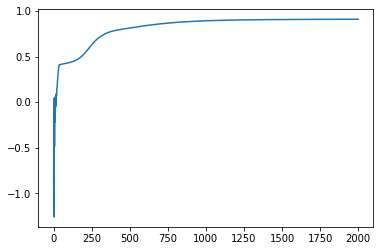

train l2 norm: 0.17590682310320008
train r2 score: 0.9103922614930888


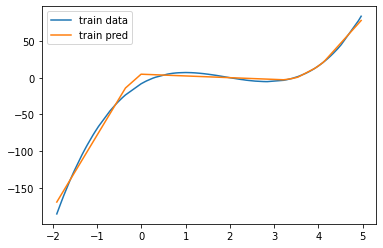

test l2 norm: 36.255259128355235
test r2 score: 0.19243764315342182


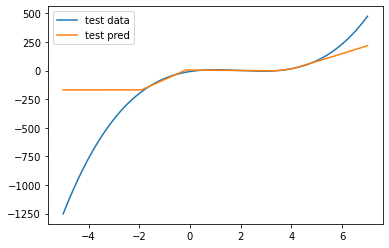

In [14]:
training_history, train_score, test_score = train(data, X, Y, test_data, test_X, test_Y, **config, problem='regression')

In [15]:
# best SIGMOID architecture

config = outs[448][0]
config

{'scale_x': True,
 'scale_y': True,
 'alpha': 1.0,
 'epochs': 5000,
 'batch_size': 50,
 'beta': 0.9,
 'n_neurons_per_layer': [1, 16, 1],
 'act_funcs': ['sigmoid', 'sigmoid', 'linear'],
 'use_bias': True}

Dense_0 1 1
Dense_1 1 16
Dense_2 16 1


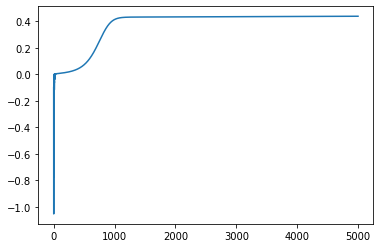

train l2 norm: 1.1053927126629557
train r2 score: 0.4369079072865971


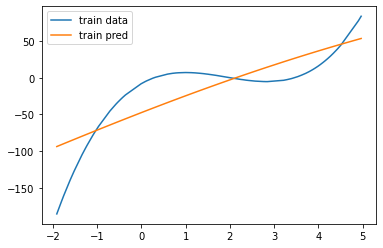

test l2 norm: 38.58555480284392
test r2 score: 0.14053182004574283


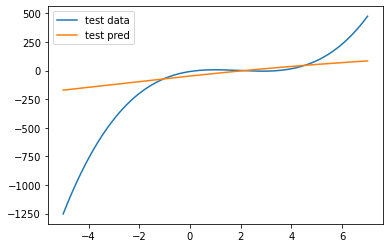

In [16]:
training_history, train_score, test_score = train(data, X, Y, test_data, test_X, test_Y, **config, problem='regression')

In [17]:
# best LINEAR architecture

config = outs[322][0]
config

{'scale_x': True,
 'scale_y': True,
 'alpha': 0.3,
 'epochs': 5000,
 'batch_size': 50,
 'beta': 0.9,
 'n_neurons_per_layer': [1, 16, 1],
 'act_funcs': ['linear', 'linear', 'linear'],
 'use_bias': True}

Dense_0 1 1
Dense_1 1 16
Dense_2 16 1


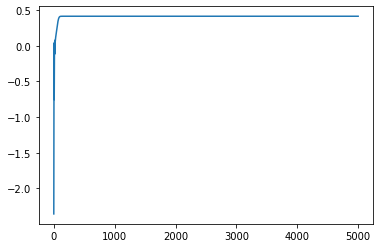

train l2 norm: 1.1480289601184843
train r2 score: 0.4151888082459104


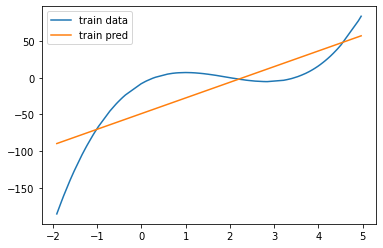

test l2 norm: 39.09151020859108
test r2 score: 0.12926199189535226


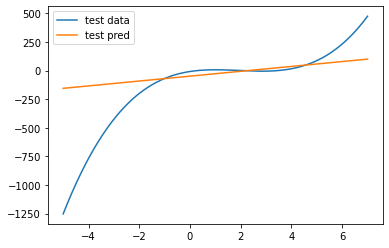

In [18]:
training_history, train_score, test_score = train(data, X, Y, test_data, test_X, test_Y, **config, problem='regression')

In [19]:
best_learning = df[(df.act_func=='relu') & (df.alpha==1) & (df.nn_p_layer==32) & (df.n_hidden_layers==2)]

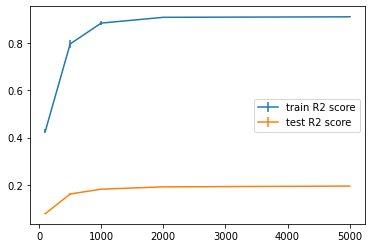

In [20]:
# R2 score during learning process of Best architecture

errorbar(best_learning.epochs, best_learning.train_mean, yerr=best_learning.train_std, label='train R2 score')
errorbar(best_learning.epochs, best_learning.test_mean, yerr=best_learning.test_std, label='test R2 score')
legend()

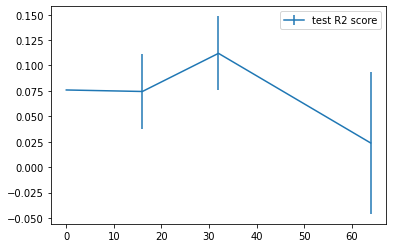

In [21]:
# R2 score by nr of neurons per hidden layer for 'relu' activation function

df2 = df[df.act_func=='relu']
gr = df2.groupby('nn_p_layer')
mean = gr.mean()
errorbar(mean.index, mean.test_mean, yerr=gr.test_mean.std(), label='test R2 score')
legend()

by mean over all tested hiperparameters, best nr of neurons per hidden layer was 32.
Other numbers couldn't learn effectively. 0 means there is no hidden layer.

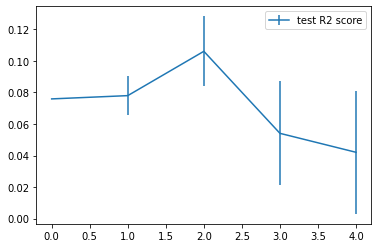

In [22]:
# R2 score by nr of neurons per hidden layer for 'relu' activation function

df2 = df[df.act_func=='relu']
gr = df2.groupby('n_hidden_layers')
mean = gr.mean()
errorbar(mean.index, mean.test_mean, yerr=gr.test_std.std(), label='test R2 score')
legend()

by mean over all tested hiperparameters, best nr of hidden layer was 2.
Other numbers couldn't learn effectively. 0 means there is no hidden layer.

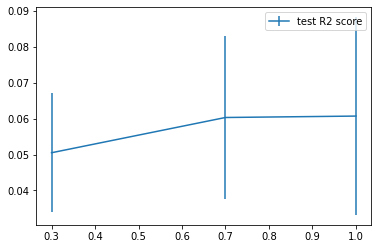

In [23]:
# R2 score by (learning rate) alpha parameter

df2 = df
gr = df2.groupby('alpha')
mean = gr.mean()
errorbar(mean.index, mean.test_mean, yerr=gr.test_std.std(), label='test R2 score')
legend()

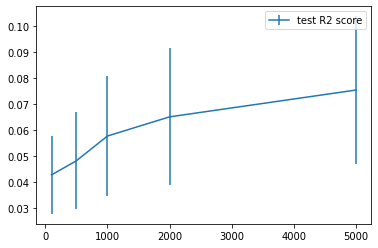

In [24]:
# R2 score by epochs number

df2 = df
gr = df2.groupby('epochs')
mean = gr.mean()
errorbar(mean.index, mean.test_mean, yerr=gr.test_std.std(), label='test R2 score')
legend()

Dense_0 1 1
Dense_1 1 32
Dense_2 32 32
Dense_3 32 1


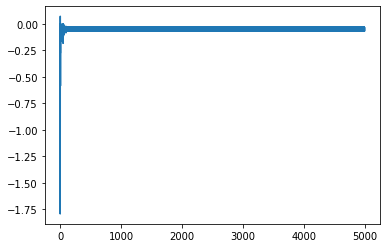

train l2 norm: 2.090955571814816
train r2 score: -0.06514231115883495


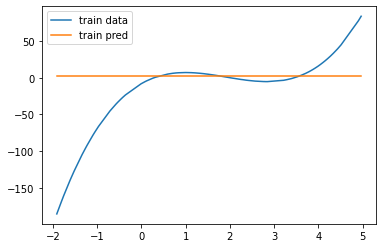

test l2 norm: 47.80021970920608
test r2 score: -0.06471885773836239


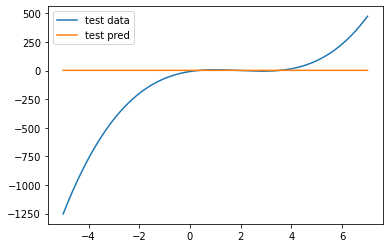

In [25]:
# EXPERIMENT 2

config = {'scale_x': True,
 'scale_y': True,
 'alpha': 1.0,
 'epochs': 5000,
 'batch_size': 50,
 'beta': 0.9,
 'n_neurons_per_layer': [1, 32, 32, 1],
 'act_funcs': ['relu', 'relu', 'relu', 'linear'],
 'use_bias': True,
 'error_function': 'l1'}
training_history, train_score, test_score = train(data, X, Y, test_data, test_X, test_Y, **config, problem='regression')